# Numerics for the SYK quantum batteries

let us start by including the relevant packages

In [2]:
include("/home/dario/Documents/ChargingPower/src/ChargingPower.jl")
using .ChargingPower

In [3]:
using SparseArrays
using KrylovKit
using ExponentialUtilities
using Graphs
using Plots
using Statistics
using SpecialFunctions
using QuadGK
using Plots
using DelimitedFiles

and let us set the parameters for the time evolution

In [4]:
min_t = 10^-2 
max_t = 10^2
number_of_points = 10^3
points = exp.(log(min_t):((log(max_t) - log(min_t)) / (number_of_points - 1)):log(max_t))

999-element Vector{Float64}:
  0.010000000000000004
  0.010092621909870477
  0.010186101701559765
  0.0102804473209331
  0.01037566678745186
  0.010471768194855211
  0.010568759711848048
  0.010666649582795396
  0.010765446128423155
  0.010865157746525389
  ⋮
 92.03731996618232
 92.889787201645
 93.75015015145291
 94.6184819472201
 95.49485639791966
 96.37934799615793
 97.27203192450553
 98.17298406188837
 99.08228099003803

## The Z-model charging power

Let us start with the Z-model battery

In [ ]:
n_majorana = 16
samples_done = 0
average_energy_list = zeros(Float64, length(points))
e_0 = -n_majorana /2

In [ ]:
n_samples = 500
energy_single_size_list = Array{Float64}[] 
majorana_matrices = majorana_operators(n_majorana)
graph = complete_graph(n_majorana)
battery_hamiltonian = Z_model_hamiltonian(majorana_matrices)
for i in 1:n_samples 
    charging_hamiltonian = SYK_hamiltonian(majorana_matrices, graph)
    ground_state_rough = eigsolve(battery_hamiltonian, rand(ComplexF64, floor(Int, 2^(n_majorana/2))), 1, :SR)
    ground_state = ground_state_rough[2][1]
    energy_list = Float64[]
    for index in eachindex(points) 
        if index == 1
            ground_state = expv(- im * points[index], charging_hamiltonian, ground_state)
        else
            ground_state = expv(- im * (points[index] - points[index-1]), charging_hamiltonian, ground_state)
        end
        push!(energy_list, (real(ground_state' * battery_hamiltonian * ground_state)))
    end
    push!(energy_single_size_list, energy_list)
end
average_energy_list = (samples_done .* average_energy_list + n_samples * mean(energy_single_size_list)) / (samples_done + n_samples)
samples_done += n_samples
samples_done

In [ ]:
theoretical_points = [-1 * (n_majorana/2) * (besselj(1, 2* t) / t)^2 for t in points]
average_power_list = [((average_energy_list[index] - e_0))/(points[index]) for index in 1:length(points)]
theoretical_power_points = [((theoretical_points[index] - e_0))/(points[index]) for index in 1:length(points)]

In [ ]:
plot(points, [average_energy_list, theoretical_points], xaxis=:log, linewidth=2, minorgrid=true)   

In [ ]:
graph = plot(points, [average_power_list, theoretical_power_points], xaxis=:log, linewidth=3, minorgrid=true, label = ["N = 16 numerical" "N = 16 analytical"], legendfontsize=8) 

In [ ]:
savefig(graph, "/home/dario/Documents/ChargingPower/plots_power/N28_Z-model_2110_samples.pdf")


In [ ]:
open("/home/dario/Documents/ChargingPower/data_power/N28_Z-model_2110_samples_points.txt", "w") do io
    writedlm(io, points, ',')
end;
open("/home/dario/Documents/ChargingPower/data_power/N28_Z-model_2110_samples_power.txt", "w") do io
    writedlm(io, average_power_list, ',')
end;

## The X-model charging power

Let us now collect the data for the X-model battery

In [ ]:
n_majorana = 28
samples_done = 0
average_energy_list = zeros(Float64, length(points))
e_0 = -n_majorana /2

In [ ]:
n_samples = 9
energy_single_size_list = Array{Float64}[] 
majorana_matrices = majorana_operators(n_majorana)
graph = complete_graph(n_majorana)
battery_hamiltonian = X_model_hamiltonian(majorana_matrices)
for i in 1:n_samples 
    charging_hamiltonian = SYK_hamiltonian(majorana_matrices, graph)
    ground_state_rough = eigsolve(battery_hamiltonian, rand(ComplexF64, floor(Int, 2^(n_majorana/2))), 1, :SR)
    e_0 = real(ground_state_rough[1][1])
    ground_state = ground_state_rough[2][1]
    energy_list = Float64[]
    for index in eachindex(points) 
        if index == 1
            ground_state = expv(- im * points[index], charging_hamiltonian, ground_state)
        else
            ground_state = expv(- im * (points[index] - points[index-1]), charging_hamiltonian, ground_state)
        end
        push!(energy_list, (real(ground_state' * battery_hamiltonian * ground_state)))
    end
    push!(energy_single_size_list, energy_list)
end
average_energy_list = (samples_done .* average_energy_list + n_samples * mean(energy_single_size_list)) / (samples_done + n_samples)
samples_done += n_samples
samples_done


In [ ]:
theoretical_points = Float64[]
for t in points
    sum = 0.0 
    for k in 1:floor(Int, n_majorana/2)
        sum += (besselj(1, 2 * t * sqrt(1 - (2 * k - 1)/n_majorana)) / (t * sqrt(1 - (2 * k - 1)/n_majorana)))^(2 * k - 1)
    end
    push!(theoretical_points,  - 1 * sum)
end
average_power_list = [((average_energy_list[index] - e_0))/(points[index]) for index in 1:length(points)]
theoretical_power_points = [((theoretical_points[index] - e_0))/(points[index]) for index in 1:length(points)]
theoretical_power_approx_points = Float64[]
for t in points
    f(x) = exp(-n_majorana/2 * t^2 * x * (1 - x))
    f_value = quadgk(f, 0, 1, rtol=1e-3)[1]
    push!(theoretical_power_approx_points,  (n_majorana / (2 * t)) * (1 - f_value))
end

In [ ]:
plot(points, [average_energy_list, theoretical_points], xaxis=:log, linewidth=2, minorgrid=true)   

In [ ]:
graph = plot(points, [average_power_list, theoretical_power_points, theoretical_power_approx_points], xaxis=:log, linewidth=3, minorgrid=true, label = ["N = 28 numeric" "N = 28 analytic full" "N = 28 analytic approximate"], legendfontsize=8) 

In [ ]:
savefig(graph, "/home/dario/Documents/ChargingPower/plots_power/N28_X-model_19_samples.pdf")


In [ ]:
open("/home/dario/Documents/ChargingPower/data_power/N28_X-model_19_samples_points.txt", "w") do io
    writedlm(io, points, ',')
end;
open("/home/dario/Documents/ChargingPower/data_power/N28_X-model_19_samples_power.txt", "w") do io
    writedlm(io, average_power_list, ',')
end;

## Plots for the complete graph

In [4]:
using LaTeXStrings

In [ ]:
points = open("/home/dario/Documents/ChargingPower/data_power/N28_X-model_19_samples_points.txt", "r") do io
    readdlm(io, ',')
end;
average_power_list = open("/home/dario/Documents/ChargingPower/data_power/N28_X-model_19_samples_power.txt", "r") do io
    readdlm(io, ',')
end;

n_majorana = 28
e_0 = - n_majorana/2

theoretical_points = Float64[]
for t in points
    sum = 0.0 
    for k in 1:floor(Int, n_majorana/2)
        sum += (besselj(1, 2 * t * sqrt(1 - (2 * k - 1)/n_majorana)) / (t * sqrt(1 - (2 * k - 1)/n_majorana)))^(2 * k - 1)
    end
    push!(theoretical_points,  - 1 * sum)
end
theoretical_power_points = [((theoretical_points[index] - e_0))/(points[index]) for index in 1:length(points)]
theoretical_power_approx_points = Float64[]
for t in points
    f(x) = exp(-n_majorana/2 * t^2 * x * (1 - x))
    f_value = quadgk(f, 0, 1, rtol=1e-3)[1]
    push!(theoretical_power_approx_points,  (n_majorana / (2 * t)) * (1 - f_value))
end

In [ ]:
graph = plot(points, [average_power_list, theoretical_power_points, theoretical_power_approx_points], xaxis=:log, linewidth=3, minorgrid=true, label = [L"N = 28 \ \mathrm{numerical}" L"N = 28 \ \mathrm{analytical}" L"N = 28 \ \mathrm{approximate}"], legendfontsize=13, xticks = ([0.01, 0.1, 1.0, 10, 100], ["0.01", "0.1", "1.0", "10", "100"]), yticks = ([0.0, 4.0, 8.0, 12], ["0.0", "4.0", "8.0", "12"]), xtickfont = font(12, ""), ytickfont = font(12, ""))

In [ ]:
savefig(graph, "/home/dario/Documents/ChargingPower/plots_power/X-model_complete_graph.pdf")

In [ ]:
points = open("/home/dario/Documents/ChargingPower/data_power/N16_Z-model_2110_samples_points.txt", "r") do io
    readdlm(io, ',')
end;
average_power_list_N16 = open("/home/dario/Documents/ChargingPower/data_power/N16_Z-model_2110_samples_power.txt", "r") do io
    readdlm(io, ',')
end;
average_power_list_N28 = open("/home/dario/Documents/ChargingPower/data_power/N28_Z-model_39_samples_power.txt", "r") do io
    readdlm(io, ',')
end;

n_majorana = 28
e_0 = - n_majorana/2

theoretical_points = [-1 * (n_majorana/2) * (besselj(1, 2* t) / t)^2 for t in points]
theoretical_power_points_N28 = [((theoretical_points[index] - e_0))/(points[index]) for index in 1:length(points)]

n_majorana = 16
e_0 = - n_majorana/2

theoretical_points = [-1 * (n_majorana/2) * (besselj(1, 2* t) / t)^2 for t in points]
theoretical_power_points_N16 = [((theoretical_points[index] - e_0))/(points[index]) for index in 1:length(points)]



In [ ]:
graph = plot(points, [average_power_list_N28, theoretical_power_points_N28, average_power_list_N16, theoretical_power_points_N16], xaxis=:log, linewidth=3, minorgrid=true, label = [L"N = 28 \ \mathrm{numerical}" L"N = 28 \ \mathrm{analytical}" L"N = 16 \ \mathrm{numerical}" L"N = 16 \ \mathrm{analytical}"], legendfontsize=13, xticks = ([0.01, 0.1, 1.0, 10, 100], ["0.01", "0.1", "1.0", "10", "100"]), yticks = ([0.0, 3.0, 6.0, 9.0], ["0.0", "3.0", "6.0", "9.0"]), xtickfont = font(12, ""), ytickfont = font(12, "") )

In [ ]:
savefig(graph, "/home/dario/Documents/ChargingPower/plots_power/Z-model_complete_graph.pdf")

## The fake $X$-model vs the true $X$-model on neighrest-neighboor graph

Let's load the data already collected

In [31]:
true_power_list = open("/home/dario/Documents/ChargingPower/data_power/fake_X_model/true_power_list.txt", "r") do io
    readdlm(io, ',')[:,1]
end;
fake_power_list = open("/home/dario/Documents/ChargingPower/data_power/fake_X_model/fake_power_list.txt", "r") do io
    readdlm(io, ',')[:,1]
end;
true_time_list = open("/home/dario/Documents/ChargingPower/data_power/fake_X_model/true_time_list.txt", "r") do io
    readdlm(io,  ',')[:,1]
end;
fake_time_list = open("/home/dario/Documents/ChargingPower/data_power/fake_X_model/fake_time_list.txt", "r") do io
    readdlm(io, ',')[:,1]
end;

In [4]:
true_power_list = Float64[]
fake_power_list = Float64[]
true_time_list = Float64[]
fake_time_list = Float64[]

Float64[]

In [78]:
n_majorana = 22
majorana_matrices = majorana_operators(n_majorana)
graph = watts_strogatz(n_majorana, 2, 0.0)
true_battery_hamiltonian = X_model_hamiltonian(majorana_matrices)
fake_battery_hamiltonian = X_model_hamiltonian(majorana_matrices)
samples_done = 0
true_average_energy_list = zeros(Float64, length(points))
theoric_e_0 = -n_majorana /2
true_ground_state_rough = eigsolve(true_battery_hamiltonian, rand(ComplexF64, floor(Int, 2^(n_majorana/2))), 1, :SR)
true_e_0 = real(true_ground_state_rough[1][1])

fake_average_energy_list = zeros(Float64, length(points))
fake_ground_state_rough = eigsolve(fake_battery_hamiltonian, rand(ComplexF64, floor(Int, 2^(n_majorana/2))), 1, :SR)
fake_e_0 = real(fake_ground_state_rough[1][1])

theoric_e_0 - fake_e_0

7.105427357601002e-15

In [ ]:
n_samples = 30
true_energy_single_size_list = Array{Float64}[]
fake_energy_single_size_list = Array{Float64}[] 
for i in 1:n_samples 
    charging_hamiltonian = SYK_hamiltonian(majorana_matrices, graph)
    ground_state = true_ground_state_rough[2][1]
    energy_list = Float64[]
    for index in eachindex(points) 
        if index == 1
            ground_state = expv(- im * points[index], charging_hamiltonian, ground_state)
        else
            ground_state = expv(- im * (points[index] - points[index-1]), charging_hamiltonian, ground_state)
        end
        push!(energy_list, (real(ground_state' * true_battery_hamiltonian * ground_state)))
    end
    push!(true_energy_single_size_list, energy_list)
end
true_average_energy_list = (samples_done .* true_average_energy_list + n_samples * mean(true_energy_single_size_list)) / (samples_done + n_samples)

for i in 1:n_samples 
    charging_hamiltonian = twisted_circle_SYK_hamiltonian(majorana_matrices, graph)
    ground_state = fake_ground_state_rough[2][1]
    energy_list = Float64[]
    for index in eachindex(points) 
        if index == 1
            ground_state = expv(- im * points[index], charging_hamiltonian, ground_state)
        else
            ground_state = expv(- im * (points[index] - points[index-1]), charging_hamiltonian, ground_state)
        end
        push!(energy_list, (real(ground_state' * fake_battery_hamiltonian * ground_state)))
    end
    push!(fake_energy_single_size_list, energy_list)
end
fake_average_energy_list = (samples_done .* fake_average_energy_list + n_samples * mean(fake_energy_single_size_list)) / (samples_done + n_samples)

samples_done += n_samples
samples_done

90

In [88]:
true_average_power_list = [((true_average_energy_list[index] - true_e_0))/(points[index]) for index in 1:length(points)]
fake_average_power_list = [((fake_average_energy_list[index] - fake_e_0))/(points[index]) for index in 1:length(points)]

999-element Vector{Float64}:
 0.28768352055159585
 0.29034720369566286
 0.29303553324213644
 0.29574873676530206
 0.2984870439290058
 0.3012506865025336
 0.3040398983807516
 0.306854915605878
 0.3096959763808553
 0.3125633210952565
 ⋮
 0.11908056569420288
 0.11737477847438611
 0.11509956902201614
 0.11405757910799497
 0.1141186413372877
 0.1128325459754242
 0.11059352816085637
 0.11195739910258233
 0.11246280681057717

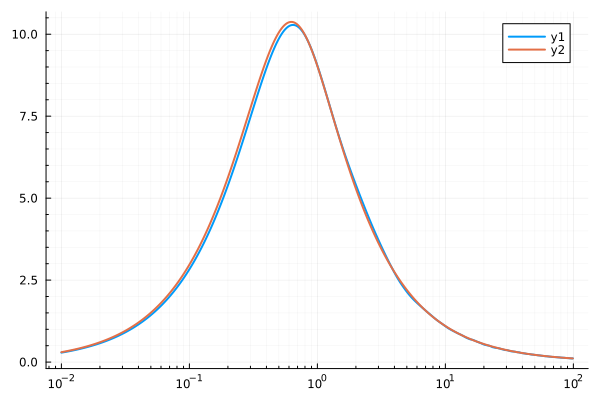

In [ ]:
plot(points[1:999], [true_average_power_list, fake_average_power_list], xaxis=:log, linewidth=2, minorgrid=true)   

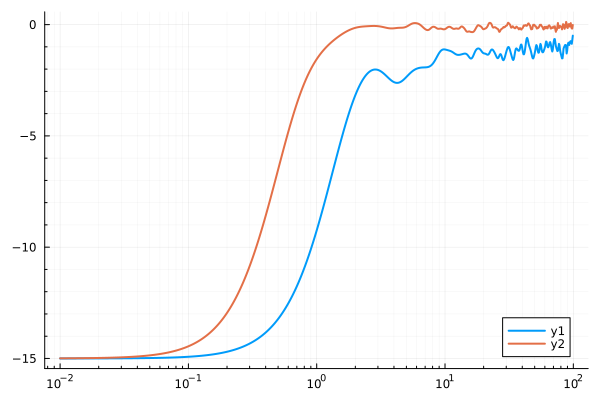

In [61]:
plot(points, [true_average_energy_list, fake_average_energy_list], xaxis=:log, linewidth=2, minorgrid=true)

In [62]:
true_max, fake_max = findmax.([true_average_power_list, fake_average_power_list])
push!(true_time_list, points[true_max[2]])
push!(fake_time_list, points[fake_max[2]])
push!(true_power_list, true_max[1])
push!(fake_power_list, fake_max[1])

9-element Vector{Float64}:
  5.586103668603119
  6.700481032222167
  8.077752603265889
  9.346900146725766
 10.66327910141624
 12.114216795786444
 13.88544159265585
 15.130647820613483
 17.056283865306714

In [63]:
true_time_list

9-element Vector{Float64}:
 1.4933932161242538
 1.4933932161242538
 1.479688062686397
 1.452653925946782
 1.4661086840469852
 1.452653925946782
 1.5072253093107575
 1.452653925946782
 1.479688062686397

In [64]:
fake_time_list

9-element Vector{Float64}:
 0.7978144572076633
 0.754879928165344
 0.7012063589007184
 0.6696160054853225
 0.6394488428556944
 0.6106407542232045
 0.5831305113526225
 0.572476623970218
 0.5466857299720185

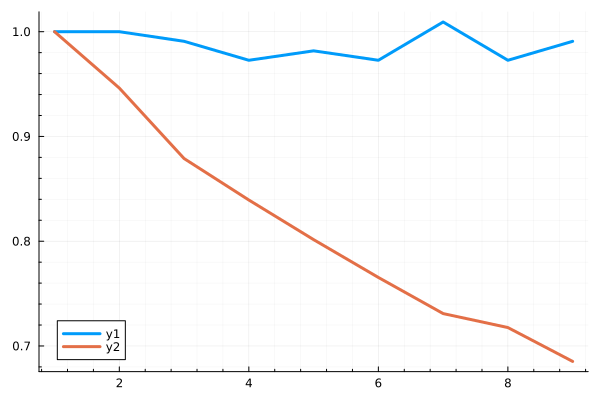

In [25]:
plot([true_time_list/true_time_list[1], fake_time_list/fake_time_list[1]], linewidth=3, minorgrid=true)

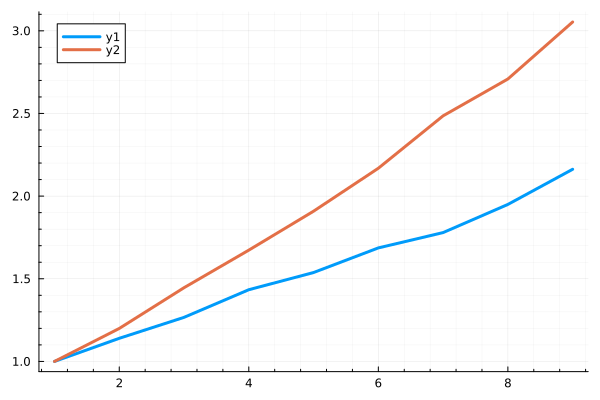

In [65]:
plot([true_power_list/true_power_list[1], fake_power_list/fake_power_list[1]], linewidth=3, minorgrid=true)

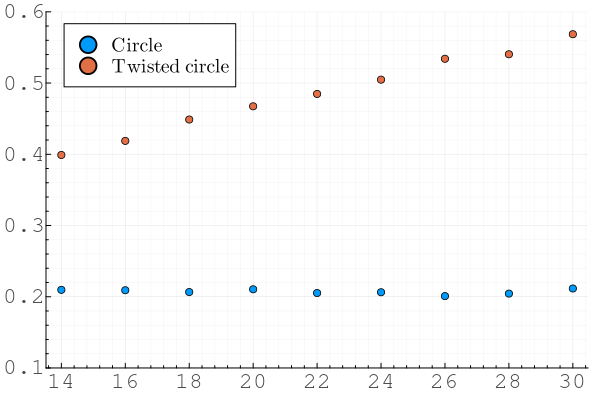

In [ ]:
graph = scatter([14:2:30], [[true_power_list[index]/(12 + 2 * index) for index in  eachindex(true_power_list)], [fake_power_list[index]/(12 + 2 * index) for index in eachindex(fake_power_list)]], minorgrid=true, label = [L"\mathrm{Circle}" L"\mathrm{Twisted} \ \mathrm{circle}"], xticks = ([14,16,18,20,22,24,26,28,30], ["14", "16", "18", "20", "22", "24", "26", "28", "30"]), legendfontsize=13,  xtickfont = font(12, ""), ytickfont = font(12, ""), ylims=(0.1,0.6))

In [24]:
savefig(graph, "/home/dario/Documents/ChargingPower/plots_power/circle_vs_twisted_circle_scaling_power.pdf")

"/home/dario/Documents/ChargingPower/plots_power/circle_vs_twisted_circle_scaling_power.pdf"

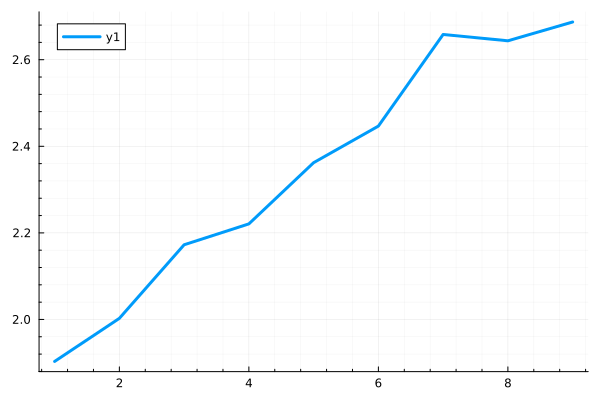

In [68]:
plot(fake_power_list./true_power_list, linewidth=3, minorgrid=true)

In [69]:
open("/home/dario/Documents/ChargingPower/data_power/fake_X_model/true_power_list.txt", "w") do io
    writedlm(io, true_power_list, ',')
end;
open("/home/dario/Documents/ChargingPower/data_power/fake_X_model/fake_power_list.txt", "w") do io
    writedlm(io, fake_power_list, ',')
end;
open("/home/dario/Documents/ChargingPower/data_power/fake_X_model/true_time_list.txt", "w") do io
    writedlm(io, true_time_list, ',')
end;
open("/home/dario/Documents/ChargingPower/data_power/fake_X_model/fake_time_list.txt", "w") do io
    writedlm(io, fake_time_list, ',')
end;

## The Watts-Strogatz graph

In [5]:
numerical_power_list = open("/home/dario/Documents/ChargingPower/data_power/watts_strogatz/numerical_power_list.txt", "r") do io
    readdlm(io, ',')[:,1]
end;
theoretical_power_list = open("/home/dario/Documents/ChargingPower/data_power/watts_strogatz/theoretical_power_list.txt", "r") do io
    readdlm(io, ',')[:,1]
end;
numerical_time_list = open("/home/dario/Documents/ChargingPower/data_power/watts_strogatz/numerical_time_list.txt", "r") do io
    readdlm(io,  ',')[:,1]
end;
theoretical_time_list = open("/home/dario/Documents/ChargingPower/data_power/watts_strogatz/theoretical_time_list.txt", "r") do io
    readdlm(io, ',')[:,1]
end;

In [38]:
numerical_power_list = Float64[]
theoretical_power_list = Float64[]
numerical_time_list = Float64[]
theoretical_time_list = Float64[]

Float64[]

In [138]:
n_majorana = 30
majorana_matrices = majorana_operators(n_majorana)
battery_hamiltonian = X_model_hamiltonian(majorana_matrices)
samples_done = 0
theoric_e_0 = -n_majorana /2
ground_state_rough = eigsolve(battery_hamiltonian, rand(ComplexF64, floor(Int, 2^(n_majorana/2))), 1, :SR)
true_e_0 = real(ground_state_rough[1][1])
average_degree = 2
g_2k_m1_average_list = zeros(floor(Int, n_majorana/2))
average_energy_list = zeros(Float64, length(points))

999-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [182]:
n_samples = 10
energy_single_size_list = Array{Float64}[]
for i in 1:n_samples 
    graph = watts_strogatz(n_majorana,average_degree,0.7)
    A_lm = adjacency_matrix(graph)
    g_2k_m1_list = Float64[]
    for k in 1:floor(Int, n_majorana/2) 
        g_2km1 = 0
        for m in 1:(2 * k - 1) 
            for l in (2 * k):n_majorana 
                g_2km1 += A_lm[l, m]
            end
        end
        push!(g_2k_m1_list, g_2km1/average_degree)
    end
    g_2k_m1_average_list = ((samples_done + i - 1) .* g_2k_m1_average_list .+ g_2k_m1_list)/(samples_done + i) 

    charging_hamiltonian = SYK_hamiltonian(majorana_matrices, graph)
    ground_state = ground_state_rough[2][1]
    energy_list = Float64[]
    for index in eachindex(points) 
        if index == 1
            ground_state = expv(- im * points[index], charging_hamiltonian, ground_state)
        else
            ground_state = expv(- im * (points[index] - points[index-1]), charging_hamiltonian, ground_state)
        end
        push!(energy_list, (real(ground_state' * battery_hamiltonian * ground_state)))
    end
    push!(energy_single_size_list, energy_list)
end
average_energy_list = (samples_done .* average_energy_list + n_samples * mean(energy_single_size_list)) / (samples_done + n_samples)

samples_done += n_samples
samples_done


110

In [183]:
function theoretical_contribution(t, g_2k_m1_average_list, n_majorana)
    sum = 0
    
    for k in 1:floor(Int, n_majorana/2)
        sum += exp((-1)/2 * g_2k_m1_average_list[k] * t^2)
    end
    return -1 * sum
end
average_power_list = [((average_energy_list[index] - true_e_0))/(points[index]) for index in 1:length(points)]
theoretical_average_power_list = [(1/t) * (n_majorana/2 +  theoretical_contribution(t, g_2k_m1_average_list, n_majorana)) for t in points]
theoretical_average_energy_list = [theoretical_contribution(t, g_2k_m1_average_list, n_majorana) for t in points]
g_2k_m1_average_list

15-element Vector{Float64}:
 1.0545454545454545
 2.2409090909090916
 3.2454545454545456
 4.213636363636366
 4.8
 5.245454545454548
 5.549999999999998
 5.649999999999999
 5.6454545454545455
 5.363636363636363
 4.890909090909093
 4.249999999999998
 3.3272727272727267
 2.3818181818181814
 1.0136363636363632

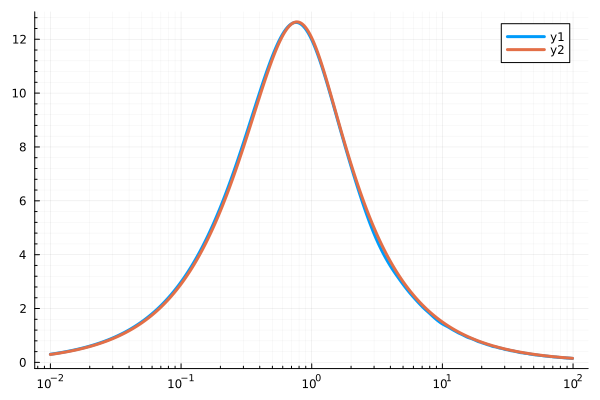

In [184]:
plot(points, [average_power_list, theoretical_average_power_list], xaxis=:log, linewidth=3, minorgrid=true)   

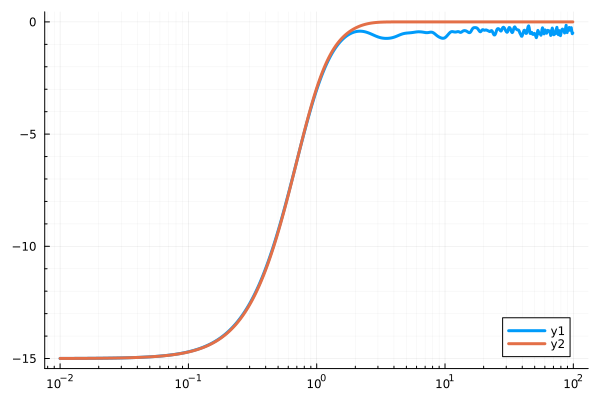

In [185]:
plot(points, [average_energy_list, theoretical_average_energy_list], xaxis=:log, linewidth=3, minorgrid=true) 

In [186]:
numerical_max, theoretical_max = findmax.([average_power_list, theoretical_average_power_list])
push!(numerical_time_list, points[numerical_max[2]])
push!(theoretical_time_list, points[theoretical_max[2]])
push!(numerical_power_list, numerical_max[1])
push!(theoretical_power_list, theoretical_max[1])

10-element Vector{Float64}:
  4.360346568339272
  5.2338844698918185
  6.15283384686928
  7.118411167337646
  8.143899489873734
  9.212128713093964
 10.364021511418601
 11.353163113923653
 11.433609055504684
 12.643912728004143

In [192]:
open("/home/dario/Documents/ChargingPower/data_power/watts_strogatz/numerical_power_list.txt", "w") do io
    writedlm(io, numerical_power_list, ',')
end;
open("/home/dario/Documents/ChargingPower/data_power/watts_strogatz/theoretical_power_list.txt", "w") do io
    writedlm(io, theoretical_power_list, ',')
end;
open("/home/dario/Documents/ChargingPower/data_power/watts_strogatz/numerical_time_list.txt", "w") do io
    writedlm(io, numerical_time_list, ',')
end;
open("/home/dario/Documents/ChargingPower/data_power/watts_strogatz/theoretical_time_list.txt", "w") do io
    writedlm(io, theoretical_time_list, ',')
end;
open("/home/dario/Documents/ChargingPower/data_power/watts_strogatz/time_points.txt", "w") do io
    writedlm(io, points, ',')
end;
open("/home/dario/Documents/ChargingPower/data_power/watts_strogatz/g_k_N_30.txt", "w") do io
    writedlm(io, g_2k_m1_average_list, ',')
end;
open("/home/dario/Documents/ChargingPower/data_power/watts_strogatz/numerical_power_N_30.txt", "w") do io
    writedlm(io, average_power_list, ',')
end;
open("/home/dario/Documents/ChargingPower/data_power/watts_strogatz/theoretical_power_N_30.txt", "w") do io
    writedlm(io, theoretical_average_power_list, ',')
end;

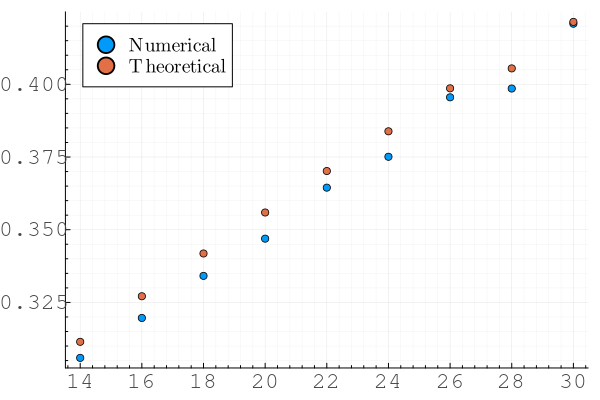

In [193]:
using LaTeXStrings
graph = scatter([14:2:30], [[numerical_power_list[index]/(12 + 2 * index) for index in  eachindex(numerical_power_list)], [theoretical_power_list[index]/(12 + 2 * index) for index in eachindex(theoretical_power_list)]], minorgrid=true, label = [L"\mathrm{Numerical}" L"\mathrm{Theoretical}"], xticks = ([14,16,18,20,22,24,26,28,30], ["14", "16", "18", "20", "22", "24", "26", "28", "30"]), legendfontsize=13,  xtickfont = font(12, ""), ytickfont = font(12, ""))

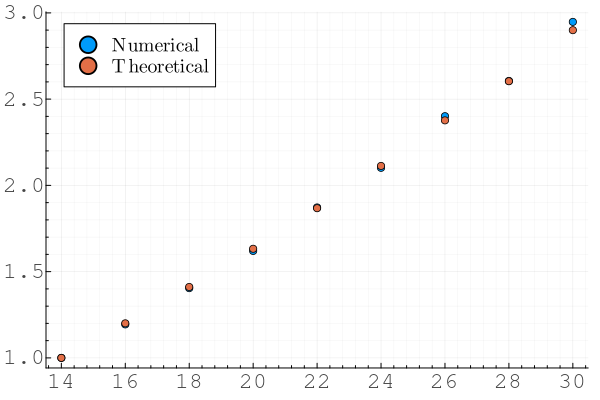

In [194]:
graph = scatter([14:2:30], [[numerical_power_list[index]/numerical_power_list[1] for index in  eachindex(numerical_power_list)], [theoretical_power_list[index]/theoretical_power_list[1] for index in eachindex(theoretical_power_list)]], minorgrid=true, label = [L"\mathrm{Numerical}" L"\mathrm{Theoretical}"], xticks = ([14,16,18,20,22,24,26,28,30], ["14", "16", "18", "20", "22", "24", "26", "28", "30"]), legendfontsize=13,  xtickfont = font(12, ""), ytickfont = font(12, ""))